## {Gaussian, Uniform} to 8-Gaussian, guidance with Learned, MC, CEG

In [22]:
%load_ext autoreload
%autoreload 2

from functools import partial
from typing import List, Tuple
from guided_flow.backbone.mlp import MLP
from guided_flow.backbone.wrapper import ExpEnergyMLPWrapper, GuidedMLPWrapper, MLPWrapper
from guided_flow.config.sampling import GuideFnConfig
from guided_flow.distributions.base import BaseDistribution, get_distribution
from guided_flow.distributions.gaussian import GaussianDistribution
from guided_flow.flow.optimal_transport import OTPlanSampler
from guided_flow.guidance.gradient_guidance import wrap_grad_fn
from guided_flow.utils.misc import deterministic
from guided_flow.utils.metrics import compute_w2 as w2
import torch
from torchdyn.core import NeuralODE
import numpy as np
from torch.distributions import Normal, Independent
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from tqdm import tqdm
from guided_flow.config.sampling import ODEConfig
from fk_steering import evaluate_fk, create_fk_guide_cfg


# from guided_flow.utils.kl_divergence import compute_kl_divergence
MLP_WIDTH = 256
TRAINING_B = 256 # OT CFM training batch size


def sample_x1_frompeJ(x1_sampler, x1_dist, device, B):
    x1 = None
    while x1 is None or x1.shape[0] < B:
        x1_ = x1_sampler(B).to(device)
        weights = torch.exp(-x1_dist.get_J(x1_))
        acc_prob = weights / weights.max()
        random_numbers = torch.rand(B, device=device)
        x1_ = x1_[random_numbers < acc_prob]
        if x1 is None:
            x1 = x1_
        else:
            x1 = torch.cat([x1, x1_], 0)
    x1 = x1[:B]
    return x1


def compute_w2(trajs, cfgs: List[GuideFnConfig]):
    w2s = []
    for traj, cfg in zip(trajs, cfgs):
        x0_dist = get_distribution(cfg.dist_pair[0])
        x1_dist = get_distribution(cfg.dist_pair[1])
        
        x1 = sample_x1_frompeJ(x1_dist.sample, x1_dist, cfg.ode_cfg.device, cfg.ode_cfg.batch_size)
        w2s.append(w2(traj[-1], x1))
    return w2s

def compute_unweighted_w2(trajs, cfgs: List[GuideFnConfig]):
    w2s = []
    for traj, cfg in zip(trajs, cfgs):
        x0_dist = get_distribution(cfg.dist_pair[0])
        x1_dist = get_distribution(cfg.dist_pair[1])

        x1 = x1_dist.sample(cfg.ode_cfg.batch_size, cfg.ode_cfg.device)
        w2s.append(w2(traj[-1], x1))
    return w2s


def get_mc_guide_fn(x0_dist: BaseDistribution, x1_dist: BaseDistribution, mc_cfg: GuideFnConfig, cfm: str):

    def log_cfm_p_t1(x1, xt, t):
        # xt = t x1 + (1 - t) x0 -> x0 = xt / (1 - t) - t / (1 - t) x1
        x0 = xt / (1 - t + mc_cfg.ep) - (t + mc_cfg.ep) / (1 - t + mc_cfg.ep) * x1 # (B, 2)
        p1t = x0_dist.prob(x0).clamp(1e-8) / (1 - t[0] + mc_cfg.ep) ** 2 # (B,)
        log_p1t = p1t.log()
        # print(log_p1t.mean())
        return log_p1t
        
    def ot_cfm_log_p_tz(x0, x1, xt, t, std=None):
        mean = t * x1 + (1 - t) * x0 # (B, 2)
         # g.t. std: 0. Too small: requires large mc_batch_size; Too large: inaccurate
        base_dist = Normal(loc=mean, scale=std)
        distribution = Independent(base_dist, 1)
        log_p1t = distribution.log_prob(xt) # (B,)
        return log_p1t
        
    def guide_fn(t, x, dx_dt, model, x0=None, x1=None, Jx1=None):
        """
        Args:
            t: Tensor, shape (b, 1)
            x: Tensor, shape (b, dim)
            dx_dt: Tensor, shape (b, dim)
            model: MLP
        """
        # estimate E (e^{-J} / Z - 1) * u
        b = x.shape[0]
        B = mc_cfg.mc_batch_size
        x_ = x.repeat(B, 1) # (MC_B * b, 2)
        t_ = t.repeat(B * b, 1) # (MC_B * b)
        if cfm == 'cfm':
            log_p_t1_x = log_cfm_p_t1(x1, x_, t_) # (MC_B * b) # TODO
            log_p_t_x = log_p_t1_x.reshape(B, b, 1).logsumexp(0) - torch.log(torch.tensor(B, device=x.device)) # (MC_B, B, 1) -> (B, 1)
            log_p_t1_x_times_J_ = (log_p_t1_x + torch.log(Jx1)).reshape(B, b, 1) # (MC_B * b) -> (MC_B, b, 1)            
            logZ = torch.logsumexp(log_p_t1_x_times_J_, 0) - torch.log(torch.tensor(B, device=x.device)) - log_p_t_x # (b, 1)

            Z = torch.exp(logZ)
            u = (x1 - x_) / (1 - t_ + mc_cfg.ep) # (MC_B * b, dim)

            g = (log_p_t1_x.reshape(B, b, 1) - log_p_t_x.unsqueeze(0)).exp() * (Jx1.reshape(B, b, 1) / (Z + 1e-8).unsqueeze(0) - 1) * u.reshape(B, b, 2) # (MC_B, b, dim)

            return g.mean(0)
        
        elif cfm == 'ot_cfm':
            log_p_tz_x = ot_cfm_log_p_tz(x0, x1, x_, t_, std=mc_cfg.ot_std) # (MC_B * b)
            log_p_t_x = log_p_tz_x.reshape(B, b, 1).logsumexp(0) - torch.log(torch.tensor(B, device=x.device)) # (MC_B, b, 1) -> (b, 1)
            log_p_tz_x_times_J_ = (log_p_tz_x + torch.log(Jx1)).reshape(B, b, 1) # (MC_B * b) -> (MC_B, b, 1)
            
            logZ = torch.logsumexp(log_p_tz_x_times_J_, 0) - torch.log(torch.tensor(B, device=x.device)) - log_p_t_x # (b, 1)
            
            Z = torch.exp(logZ)
            u = x1 - x0 # (MC_B * b, dim)
            
            g = (log_p_tz_x.reshape(B, b, 1) - log_p_t_x.unsqueeze(0)).exp() * (Jx1.reshape(B, b, 1) / Z - 1) * u.reshape(B, b, 2) # (MC_B, b, dim)
            
            return g.mean(0)

    
    if cfm == 'cfm':
        x1 = x1_dist.sample(mc_cfg.mc_batch_size).to(mc_cfg.ode_cfg.device).unsqueeze(0).repeat(mc_cfg.ode_cfg.batch_size, 1, 1).permute(1, 0, 2).reshape(-1, 2)
        Jx1 = torch.exp(-mc_cfg.scale * x1_dist.get_J(x1))
        return partial(
            guide_fn, 
            x1=x1, 
            Jx1=Jx1
        )
    elif cfm == 'ot_cfm':
        x0 = x0_dist.sample(mc_cfg.mc_batch_size) # (MC_B, 2)
        x1 = x1_dist.sample(mc_cfg.mc_batch_size) # (MC_B, 2)
        x0_ = x0.to(mc_cfg.ode_cfg.device).unsqueeze(0).repeat(mc_cfg.ode_cfg.batch_size, 1, 1).permute(1, 0, 2).reshape(-1, 2)
        x1_ = x1.to(mc_cfg.ode_cfg.device).unsqueeze(0).repeat(mc_cfg.ode_cfg.batch_size, 1, 1).permute(1, 0, 2).reshape(-1, 2)
        J_ = torch.exp(-mc_cfg.scale * x1_dist.get_J(x1_)) # (MC_B * b)
        
        return partial(
            guide_fn, 
            x0=x0_, 
            x1=x1_, 
            Jx1=J_
        )

def get_guide_fn(dist: BaseDistribution, cfg: GuideFnConfig):
    def guide_fn(t, x, dx_dt, model):

        if cfg.guide_type == 'g_cov_A':
            x1_pred = x + dx_dt * (1 - t)
            J = dist.get_J(x1_pred)
            try:
                with torch.enable_grad():
                    x1_pred = x1_pred.requires_grad_(True)
                    J = dist.get_J(x1_pred)
                    grad = -torch.autograd.grad(J.sum(), x1_pred, create_graph=True)[0]
                    return grad
            except Exception as e:
                return torch.zeros_like(x)
        
        elif cfg.guide_type == 'g_cov_G':
            with torch.enable_grad():
                x = x.requires_grad_(True)
                x1_pred = x + model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1)) * (1 - t)
                J = dist.get_J(x1_pred)
                try:
                    grad = -torch.autograd.grad(J.sum(), x, create_graph=True)[0]
                    return grad
                except Exception as e:
                    return torch.zeros_like(x)
        else:
            raise ValueError(f"Unknown guide function: {cfg.guide_type}")
    # make scale and schedule
    return wrap_grad_fn(cfg.guide_scale, cfg.guide_schedule, guide_fn)

def get_sim_mc_guide_fn(x1_dist: BaseDistribution, cfg: GuideFnConfig):
    def guide_fn(t, x, dx_dt, model):
        """
        Implements guidance following Eq. 12
        Args:
            t: flow time. float
            x: current sample x_t. Tensor, shape (b, dim)
            dx_dt: current predicted VF. Tensor, shape (b, dim)
            model: flow model. MLP
        """
        x1_pred = x + dx_dt * (1 - t) # (B, 2)
        std = cfg.sim_mc_std
        
        x1 = torch.randn_like(x1_pred.unsqueeze(0).repeat(cfg.sim_mc_n, 1, 1)) * std + x1_pred # (cfg.sim_mc_n, B, 2)
        Jx1_ = torch.exp(-cfg.scale * x1_dist.get_J(x1.reshape(-1, 2))).reshape(cfg.sim_mc_n, -1) # (cfg.sim_mc_n, B)
        v = (x1 - x) / (1 - t + cfg.ep)  # Conditional VF v_{t|z} in Eq. 12 (cfg.sim_mc_n, B, 2)
        Z = Jx1_.mean(0) + 1e-8  # Z in Eq. 12 (B,)
        g = (Jx1_ / Z - 1).unsqueeze(2) * v  # g in Eq. 12 (cfg.sim_mc_n, B, 2)
        return g.mean(0)
    return wrap_grad_fn(cfg.guide_scale, cfg.guide_schedule, guide_fn)

def evaluate(x0_sampler, x1_sampler, model, guide_fn, cfg: ODEConfig):
    node = NeuralODE(
        GuidedMLPWrapper(
            model, 
            guide_fn=guide_fn,
            scheduler=lambda t: 1
        ), 
        solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4
    )

    with torch.no_grad():
        traj = node.trajectory(
            x0_sampler(cfg.batch_size).to(cfg.device), 
            t_span=torch.linspace(0, cfg.t_end, cfg.num_steps)
        )
    
    return traj


def sample_and_compute_w2(guide_cfgs: List[GuideFnConfig]):
    print("Monte Carlo batch size:", guide_cfgs[0].mc_batch_size)

    trajs = []

    for cfg in guide_cfgs:

        # Initialize samplers, model and guidance model
        x0_dist = get_distribution(cfg.dist_pair[0])
        x1_dist = get_distribution(cfg.dist_pair[1])

        x0_sampler = x0_dist.sample
        x1_sampler = x1_dist.sample

        model = MLP(dim=2, w=MLP_WIDTH, time_varying=True).to(cfg.ode_cfg.device)
        model.load_state_dict(torch.load(f'../logs/{cfg.dist_pair[0]}-{cfg.dist_pair[1]}/{cfg.cfm}_{cfg.dist_pair[0]}_{cfg.dist_pair[1]}/{cfg.cfm}_{cfg.dist_pair[0]}_{cfg.dist_pair[1]}.pth'))

        if cfg.guide_type == 'mc':
            # sample using flow model
            traj = evaluate(x0_sampler, x1_sampler, model, get_mc_guide_fn(x0_dist, x1_dist, cfg, cfg.cfm), cfg.ode_cfg)

        elif cfg.guide_type == 'learned':
            model_G = MLP(dim=2, out_dim=2, w=MLP_WIDTH, time_varying=True).to(cfg.ode_cfg.device)
            model_G.load_state_dict(torch.load(f'../logs/{cfg.dist_pair[0]}-{cfg.dist_pair[1]}/{cfg.cfm}_{cfg.dist_pair[0]}_{cfg.dist_pair[1]}/guidance_matching_{cfg.gm_type}_scale_{cfg.scale}_{cfg.dist_pair[0]}_{cfg.dist_pair[1]}.pth'))
            traj = evaluate(x0_sampler, x1_sampler, model, MLPWrapper(model_G, scheduler=lambda t: 1., clamp=0), cfg.ode_cfg)
        
        elif cfg.guide_type == 'ceg':
            model_Z = MLP(dim=2, out_dim=1, w=MLP_WIDTH, time_varying=True, exp_final=False).to(cfg.ode_cfg.device)
            model_Z.load_state_dict(torch.load(f'../logs/{cfg.dist_pair[0]}-{cfg.dist_pair[1]}/{cfg.cfm}_{cfg.dist_pair[0]}_{cfg.dist_pair[1]}/ceg_scale_{cfg.scale}_{cfg.dist_pair[0]}_{cfg.dist_pair[1]}.pth'))
            
            # 2D xy plane. make uniform grid
            XX = torch.linspace(0, 1, 100)
            YY = torch.linspace(0, 1, 100)
            XX, YY = torch.meshgrid(XX, YY, indexing='ij')
            xy = torch.stack([XX.flatten(), YY.flatten()], 1)
            t = torch.zeros(10000, 1) + 0.9
            fig, ax = plt.subplots()
            ax.imshow(model_Z(torch.cat([xy, t], 1).to(cfg.ode_cfg.device)).detach().cpu().numpy().reshape(100, 100))
            
            traj = evaluate(x0_sampler, x1_sampler, model, ExpEnergyMLPWrapper(model_Z, scheduler=lambda t: 1, clamp=1), cfg.ode_cfg)
        
        elif cfg.guide_type in ['g_cov_A', 'g_cov_G']:
            traj = evaluate(x0_sampler, x1_sampler, model, get_guide_fn(x1_dist, cfg), cfg.ode_cfg)

        elif cfg.guide_type == 'g_sim_MC':
            traj = evaluate(x0_sampler, x1_sampler, model, get_sim_mc_guide_fn(x1_dist, cfg), cfg.ode_cfg)
        elif cfg.guide_type == 'fk':
            traj = evaluate_fk(x0_sampler, x1_sampler, model, x1_dist, cfg.fk_params, cfg.ode_cfg)
        elif cfg.guide_type == 'plain' or cfg.guide_type == 'cfm':
            # Plain CFM without any guidance
            node = NeuralODE(
                MLPWrapper(model, scheduler=lambda t: 1, clamp=0),  # No guidance (scheduler returns 0)
                solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4
            )
            with torch.no_grad():
                traj = node.trajectory(
                    x0_sampler(cfg.ode_cfg.batch_size).to(cfg.ode_cfg.device),
                    t_span=torch.linspace(0, cfg.ode_cfg.t_end, cfg.ode_cfg.num_steps)
                )

        trajs.append(traj)
    return trajs, None

deterministic(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
num_steps = 40
mc_batch_size = 10240
disp_traj_batch = 128
ode_batch_size = 1024
cfm = 'ot_cfm'

In [24]:
guide_cfgs_mc_cfm = [
    GuideFnConfig(cfm="cfm", dist_pair=('circle', 's_curve'), mc_batch_size=mc_batch_size, ep=5e-2, scale=1, ode_cfg=ODEConfig(t_end=1.0, num_steps=num_steps, device='cuda:0', batch_size=ode_batch_size), disp_traj_batch=disp_traj_batch), 
    GuideFnConfig(cfm="cfm", dist_pair=('uniform', '8gaussian'), mc_batch_size=mc_batch_size, ep=1e-3, ode_cfg=ODEConfig(t_end=1, num_steps=num_steps, device='cuda:0', batch_size=ode_batch_size), disp_traj_batch=disp_traj_batch), 
    GuideFnConfig(cfm="cfm", dist_pair=('8gaussian', 'moon'), mc_batch_size=mc_batch_size, ep=1e-2, scale=1, ode_cfg=ODEConfig(t_end=1.0, num_steps=num_steps, device='cuda:0', batch_size=ode_batch_size), disp_traj_batch=disp_traj_batch), 
]

deterministic(0)
trajs_mc_cfm, w2s_mc_cfm = sample_and_compute_w2(guide_cfgs_mc_cfm)
compute_w2(trajs_mc_cfm, guide_cfgs_mc_cfm)

Monte Carlo batch size: 10240


/tmp/ipykernel_2333814/3128408257.py:235: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../logs/{cfg.dist_pair[0]}-{cfg.dist_pair[1]}/{cfg

[0.3460798559184829, 0.20576434674641925, 0.10966435191182855]

In [25]:
guide_cfgs_mc_ot_cfm = [
    GuideFnConfig(cfm=cfm, dist_pair=('circle', 's_curve'), mc_batch_size=mc_batch_size, ep=0.05, ot_std=0.3, scale=1, ode_cfg=ODEConfig(t_end=1.0, num_steps=num_steps, device='cuda:0', batch_size=ode_batch_size), disp_traj_batch=disp_traj_batch), 
    GuideFnConfig(cfm=cfm, dist_pair=('uniform', '8gaussian'), mc_batch_size=mc_batch_size, ep=0.05, ot_std=0.3, scale= 1, ode_cfg=ODEConfig(t_end=1, num_steps=num_steps, device='cuda:0', batch_size=ode_batch_size), disp_traj_batch=disp_traj_batch), 
    GuideFnConfig(cfm=cfm, dist_pair=('8gaussian', 'moon'), mc_batch_size=mc_batch_size, ep=0.05, ot_std=0.3, scale=1, ode_cfg=ODEConfig(t_end=1.0, num_steps=num_steps, device='cuda:0', batch_size=ode_batch_size), disp_traj_batch=disp_traj_batch), 
]

deterministic(0)
trajs_mc_ot_cfm, w2s_mc_ot_cfm = sample_and_compute_w2(guide_cfgs_mc_ot_cfm)
compute_w2(trajs_mc_ot_cfm, guide_cfgs_mc_ot_cfm)

Monte Carlo batch size: 10240


/tmp/ipykernel_2333814/3128408257.py:235: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../logs/{cfg.dist_pair[0]}-{cfg.dist_pair[1]}/{cfg

[0.23906145449373967, 0.37581798163037033, 0.24398631076786498]

In [37]:
num_samples = 128
fk_steps = 40

guide_cfgs_fk_cfm = [
    create_fk_guide_cfg(
        cfm="cfm",
        dist_pair=('circle', 's_curve'),
        scale=1.0,
        num_samples=num_samples,
        fk_steering_temperature=1.0,
        fk_potential_scheduler='harmonic_sum',
        resample_freq=10,
        resample_method='residual',
        ode_cfg=ODEConfig(t_end=1.0, num_steps=fk_steps, batch_size=ode_batch_size)
    ),
    create_fk_guide_cfg(
        cfm="cfm",
        dist_pair=('uniform', '8gaussian'),
        scale=1.0,
        num_samples=num_samples,
        resample_freq=10,
        fk_potential_scheduler='harmonic_sum',
        resample_method='residual',
        ode_cfg=ODEConfig(t_end=1.0, num_steps=fk_steps, batch_size=ode_batch_size)
    ),
    create_fk_guide_cfg(
        cfm="cfm",
        dist_pair=('8gaussian', 'moon'),
        scale=1.0,
        num_samples=num_samples,
        resample_freq=10,
        fk_potential_scheduler='harmonic_sum',
        resample_method='residual',
        ode_cfg=ODEConfig(t_end=1.0, num_steps=fk_steps, batch_size=ode_batch_size)
    ),
]
deterministic(1)

trajs_fk_cfm, w2s_fk_cfm = sample_and_compute_w2(guide_cfgs_fk_cfm)
compute_w2(trajs_fk_cfm, guide_cfgs_fk_cfm)

Monte Carlo batch size: 1024


/tmp/ipykernel_2333814/3128408257.py:235: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../logs/{cfg.dist_pair[0]}-{cfg.dist_pair[1]}/{cfg

[0.2167424749143334, 0.14720775102387132, 0.10994177127156354]

In [38]:
num_samples = 128
fk_steps = 40

guide_cfgs_fk_ot_cfm = [
    create_fk_guide_cfg(
        cfm=cfm,
        dist_pair=('circle', 's_curve'),
        scale=1.0,
        num_samples=num_samples,
        fk_steering_temperature=1.0,
        fk_potential_scheduler='harmonic_sum',
        resample_method='residual',
        resample_freq=10,
        ode_cfg=ODEConfig(t_end=1.0, num_steps=fk_steps, batch_size=ode_batch_size)
    ),
    create_fk_guide_cfg(
        cfm=cfm,
        dist_pair=('uniform', '8gaussian'),
        scale=1.0,
        num_samples=num_samples,
        resample_freq=10,
        fk_potential_scheduler='harmonic_sum',
        resample_method='residual',
        ode_cfg=ODEConfig(t_end=1.0, num_steps=fk_steps, batch_size=ode_batch_size)
    ),
    create_fk_guide_cfg(
        cfm=cfm,
        dist_pair=('8gaussian', 'moon'),
        scale=1.0,
        num_samples=num_samples,
        resample_freq=10,
        fk_potential_scheduler='harmonic_sum',
        resample_method='residual',
        ode_cfg=ODEConfig(t_end=1.0, num_steps=fk_steps, batch_size=ode_batch_size)
    ),
]
deterministic(0)

trajs_fk_ot_cfm, w2s_fk_ot_cfm = sample_and_compute_w2(guide_cfgs_fk_ot_cfm)
compute_w2(trajs_fk_ot_cfm, guide_cfgs_fk_ot_cfm)


Monte Carlo batch size: 1024


/tmp/ipykernel_2333814/3128408257.py:235: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../logs/{cfg.dist_pair[0]}-{cfg.dist_pair[1]}/{cfg

[0.24362046900326023, 0.07230156491300228, 0.07852409385546293]

In [ ]:
guide_cfgs_plain_ot_cfm = [
    GuideFnConfig(
        cfm=cfm,
        dist_pair=('circle', 's_curve'),
        guide_type='plain',
        scale=1,
        ode_cfg=ODEConfig(t_end=1.0, num_steps=num_steps, batch_size=ode_batch_size)
    ),
    GuideFnConfig(
        cfm=cfm,
        dist_pair=('uniform', '8gaussian'),
        guide_type='plain',
        scale=1,
        ode_cfg=ODEConfig(t_end=1.0, num_steps=num_steps, batch_size=ode_batch_size)
    ),
    GuideFnConfig(
        cfm=cfm,
        dist_pair=('8gaussian', 'moon'),
        guide_type='plain',
        ode_cfg=ODEConfig(t_end=1.0, num_steps=num_steps, batch_size=ode_batch_size)
    ),
]

deterministic(0)
trajs_plain_ot_cfm, _ = sample_and_compute_w2(guide_cfgs_plain_ot_cfm)
compute_unweighted_w2(trajs_plain_ot_cfm, guide_cfgs_plain_ot_cfm)

Monte Carlo batch size: 1024


/tmp/ipykernel_2333814/3128408257.py:235: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../logs/{cfg.dist_pair[0]}-{cfg.dist_pair[1]}/{cfg

[0.13415568326626276, 0.102487450195423, 0.07960520275980523]

In [46]:
guide_cfgs_plain_cfm = [
    GuideFnConfig(
        cfm="cfm",
        dist_pair=('circle', 's_curve'),
        guide_type='plain',
        scale=1,
        ode_cfg=ODEConfig(t_end=1.0, num_steps=num_steps, batch_size=ode_batch_size)
    ),
    GuideFnConfig(
        cfm="cfm",
        dist_pair=('uniform', '8gaussian'),
        guide_type='plain',
        scale=1,
        ode_cfg=ODEConfig(t_end=1.0, num_steps=num_steps, batch_size=ode_batch_size)
    ),
    GuideFnConfig(
        cfm="cfm",
        dist_pair=('8gaussian', 'moon'),
        guide_type='plain',
        ode_cfg=ODEConfig(t_end=1.0, num_steps=num_steps, batch_size=ode_batch_size)
    ),
]

deterministic(0)
trajs_plain_cfm, _ = sample_and_compute_w2(guide_cfgs_plain_cfm)
compute_unweighted_w2(trajs_plain_cfm, guide_cfgs_plain_cfm)

Monte Carlo batch size: 1024


/tmp/ipykernel_2333814/3128408257.py:235: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../logs/{cfg.dist_pair[0]}-{cfg.dist_pair[1]}/{cfg

[0.21697788896647502, 0.09263347212927052, 0.09203456747498197]

/tmp/ipykernel_2333814/2427296802.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blue = cm.get_cmap('coolwarm', 2)(0)
/tmp/ipykernel_2333814/2427296802.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  red = cm.get_cmap('coolwarm', 2)(1)


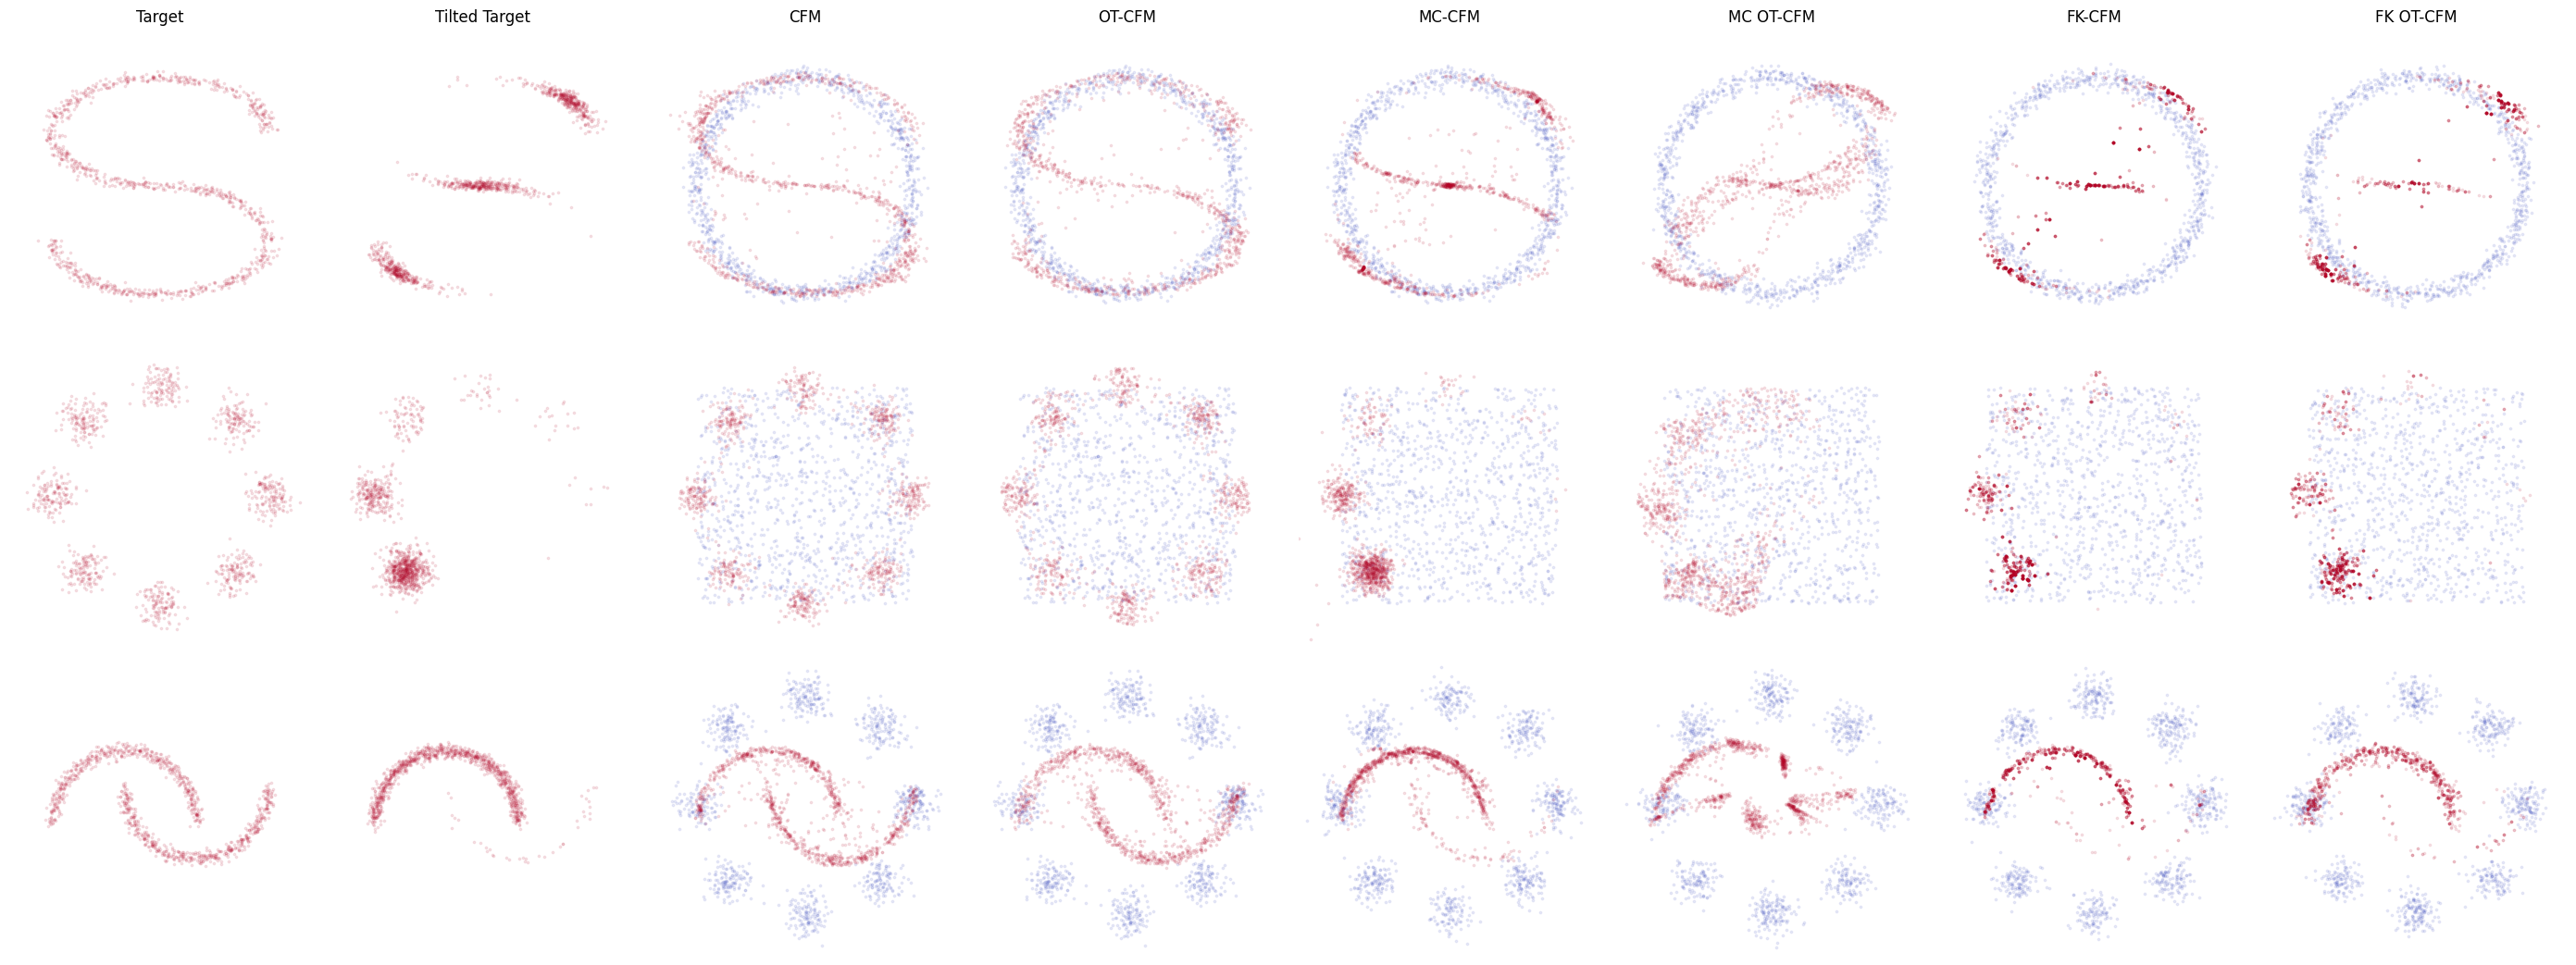

In [47]:
def plot_traj(trajs, cfgs: List[GuideFnConfig], disp_b, ncols, skip_ref=False, 
              skip_first_col=False, titles=None, show_paths=True, rasterize_dots=True):
    blue = cm.get_cmap('coolwarm', 2)(0)
    red = cm.get_cmap('coolwarm', 2)(1)

    # Calculate number of columns based on options
    num_cols = ncols
    if not skip_first_col:
        num_cols += 2
    else:
        num_cols += 1

    # Calculate figure size to make each subplot roughly square
    subplot_size = 3.5  # Size of each subplot in inches
    fig_width = num_cols * subplot_size
    fig_height = 3 * subplot_size  # 3 rows
    
    # visualize, no VF
    fig, axs = plt.subplots(3, num_cols, figsize=(fig_width, fig_height))
    
    # Ensure axs is always 2D array for consistent indexing
    if num_cols == 1:
        axs = axs.reshape(3, 1)

    size_ratio = 0.7
    ndata = 3
    nref = 1 if skip_first_col else 2
    nmethods = ncols - nref

    col_offset = 0  # Track column offset for plotting

    # 1. plot ref distributions
    for i in range(ndata):
        if skip_ref:
            break
        cfg = cfgs[i*ncols]
        x0_dist = get_distribution(cfg.dist_pair[0])
        x1_dist = get_distribution(cfg.dist_pair[1])
        x0_sampler = x0_dist.sample
        x1_sampler = x1_dist.sample
        x1 = x1_sampler(1024).to(cfg.ode_cfg.device)

        # First reference column (skip if skip_first_col is True)
        if not skip_first_col:
            ax = axs[i, 0]
            ax.scatter(x1[:, 0].cpu(), x1[:, 1].cpu(), s=3, alpha=0.1, color=red, 
                      rasterized=rasterize_dots)
            ax.set_xlim(-cfg.xlim * size_ratio, cfg.xlim * size_ratio)
            ax.set_ylim(-cfg.ylim * size_ratio, cfg.ylim * size_ratio)
            ax.axis('off')
            ax.set_aspect('equal')
            # Add title for first column
            if i == 0:
                ax.set_title("Target", fontsize=12, pad=10)
            col_offset = 1

        # Second reference column (always include if not skip_ref)
        ax = axs[i, col_offset]
        # use rejection sampling to sample with weight e^-J in x1
        x1 = sample_x1_frompeJ(x1_sampler, x1_dist, cfg.ode_cfg.device, 1024)
        ax.scatter(x1[:, 0].cpu(), x1[:, 1].cpu(), s=3, alpha=0.1, color=red,
                  rasterized=rasterize_dots)
        ax.set_xlim(-cfg.xlim * size_ratio, cfg.xlim * size_ratio)
        ax.set_ylim(-cfg.ylim * size_ratio, cfg.ylim * size_ratio)
        ax.set_ylabel(x0_dist.__name__() + '$\\rightarrow$' + x1_dist.__name__())
        ax.axis('off')
        ax.set_aspect('equal')
        # Add title for second column
        if i == 0:
            ax.set_title("Tilted Target", fontsize=12, pad=10)

    # 2. plot different methods
    for i in range(3):
        for j in range(ncols):
            try:
                traj = trajs[i * ncols + j]
                cfg = cfgs[i * ncols + j]
            except:
                continue

            # Calculate correct column index
            plot_col = j + (2 if not skip_first_col else 1)
            ax = axs[i, plot_col]
            
            # plot the start and end points with endpoint colors in the colormap
            idx = torch.randperm(cfg.ode_cfg.batch_size)[:disp_b]
            ax.scatter(traj[0, :, 0].cpu(), traj[0, :, 1].cpu(), s=3, alpha=0.1, 
                      color=blue, rasterized=rasterize_dots)
            ax.scatter(traj[-1, :, 0].cpu(), traj[-1, :, 1].cpu(), s=3, alpha=0.1, 
                      color=red, rasterized=rasterize_dots)
            
            # plot the trajectory with a gradient color (optional)
            if show_paths:
                colors = torch.linspace(0, 1, cfg.ode_cfg.num_steps).unsqueeze(1).repeat(1, disp_b).flatten().numpy()
                ax.scatter(
                    traj[:, idx, 0].flatten().cpu(),
                    traj[:, idx, 1].flatten().cpu(),
                    c=plt.cm.coolwarm(colors),
                    alpha=0.2, s=0.1, marker='.',
                    rasterized=rasterize_dots
                )
            
            ax.set_xlim(-cfg.xlim * size_ratio, cfg.xlim * size_ratio)
            ax.set_ylim(-cfg.ylim * size_ratio, cfg.ylim * size_ratio)
            ax.axis('off')
            ax.set_aspect('equal')

    # 3. Add column titles for methods if provided
    if titles is not None:
        title_start_col = 2 if not skip_first_col else 1
        for j, title in enumerate(titles):
            if j + title_start_col < num_cols:
                axs[0, j + title_start_col].set_title(title, fontsize=12, pad=10)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    return fig

# Usage example:
def transpose(lst):
    return [list(i) for i in zip(*lst)]

def flatten(lst):
    return [item for sublist in lst for item in sublist]

trajs = [trajs_plain_cfm, trajs_plain_ot_cfm, trajs_mc_cfm, trajs_mc_ot_cfm, trajs_fk_cfm, trajs_fk_ot_cfm]
cfgs = [guide_cfgs_plain_cfm, guide_cfgs_plain_ot_cfm, guide_cfgs_mc_cfm, guide_cfgs_mc_ot_cfm, guide_cfgs_fk_cfm, guide_cfgs_fk_ot_cfm]

# Define titles for your methods
method_titles = ['CFM', 'OT-CFM', 'MC-CFM', 'MC OT-CFM', 'FK-CFM', 'FK OT-CFM']

fig = plot_traj(
    flatten(transpose(trajs)), 
    flatten(transpose(cfgs)), 
    256, 
    len(cfgs),
    skip_first_col=False,
    titles=method_titles,
    show_paths=False,
    rasterize_dots=True  # This makes the dots rasterized in PDF
)

# Save as PDF with rasterized dots but vector text
fig.savefig('guidance_comp.pdf', dpi=300, bbox_inches='tight')

/tmp/ipykernel_2333814/2427296802.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blue = cm.get_cmap('coolwarm', 2)(0)
/tmp/ipykernel_2333814/2427296802.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  red = cm.get_cmap('coolwarm', 2)(1)
/home/konstantin.mark/projects/flow_guidance/synthetic/guided_flow/distributions/moon.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY

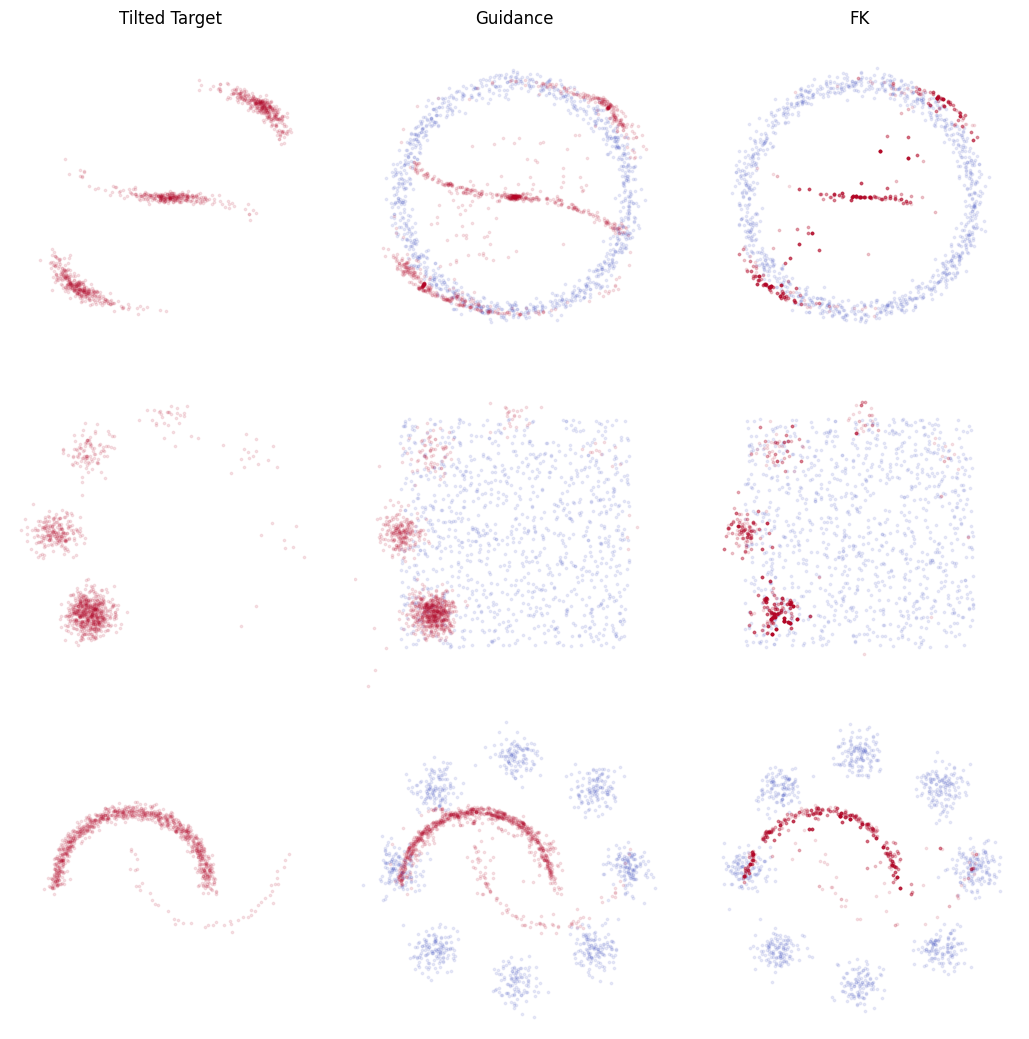

In [48]:

trajs = [ trajs_mc_cfm,  trajs_fk_cfm]
cfgs = [guide_cfgs_mc_cfm,  guide_cfgs_fk_cfm]

# Define titles for your methods
method_titles = ['Guidance', 'FK']

fig = plot_traj(
    flatten(transpose(trajs)), 
    flatten(transpose(cfgs)), 
    256, 
    len(cfgs),
    skip_first_col=True,  # Set to True to skip the first reference column
    titles=method_titles,  # Add your column titles here
    show_paths=False,       # Set to False to disable trajectory paths
    rasterize_dots=True     # This makes the dots rasterized in PNG
)
fig.savefig('guidance_comp_small.pdf', dpi=300, bbox_inches='tight')

In [49]:
# Print a table of the wasserstein distances:
for traj, cfg in zip(trajs, cfgs):
    w2s = compute_w2(traj, cfg)
    print(cfg[0].dist_pair, end=' & ')
    print([f"{w2:.2f}" for w2 in w2s])

/home/konstantin.mark/projects/flow_guidance/synthetic/guided_flow/distributions/moon.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.l

('circle', 's_curve') & ['0.35', '0.19', '0.10']
('circle', 's_curve') & ['0.22', '0.17', '0.12']


In [50]:
fig.savefig('toy.png', dpi=100, bbox_inches='tight',  pad_inches=0)

In [12]:
print(trajs_fk_cfm)

[tensor([[[-8.1276e-01,  5.9798e-01],
         [-9.6705e-01, -1.0172e-01],
         [ 1.0334e+00,  1.6321e-01],
         ...,
         [-1.0395e+00, -9.0054e-03],
         [-1.0076e+00, -2.1569e-01],
         [ 6.6674e-01, -7.3653e-01]],

        [[-7.7595e-01,  5.6766e-01],
         [-9.0888e-01, -9.4668e-02],
         [ 9.8879e-01,  1.4898e-01],
         ...,
         [-9.9711e-01, -4.1239e-03],
         [-9.6358e-01, -2.0420e-01],
         [ 6.3229e-01, -7.0537e-01]],

        [[-7.4001e-01,  5.3943e-01],
         [-8.4224e-01, -8.8464e-02],
         [ 9.5131e-01,  1.3531e-01],
         ...,
         [-9.6088e-01,  7.0453e-04],
         [-9.2348e-01, -1.9311e-01],
         [ 5.9927e-01, -6.7392e-01]],

        ...,

        [[-3.7960e-01, -6.5332e-01],
         [-6.9888e-01, -7.1833e-01],
         [-4.8883e-01, -2.1025e-01],
         ...,
         [-4.5313e-01, -9.0060e-01],
         [-7.5610e-01,  1.4661e-01],
         [ 2.6727e-01,  5.5355e-01]],

        [[-4.1766e-01, -7.3670e-0

In [13]:
# Count the unique entries in trajs_fk_cfm
for i in range(len(trajs_fk_cfm)):
    print(f"Trajectory {i} has {trajs_fk_cfm[i].shape[0]} steps and {trajs_fk_cfm[i].shape[1]} samples")
    # flatten into a steps * samples array of 2d vectors
    traj_flat = trajs_fk_cfm[i].reshape(-1, 2)
    print(traj_flat.shape)
    # Count unique along the first dimension (up to a tolerance of 0.001)
    print(np.unique(traj_flat.cpu(), axis=0).shape[0], "unique samples")

Trajectory 0 has 20 steps and 1024 samples
torch.Size([20480, 2])
14137 unique samples
Trajectory 1 has 20 steps and 1024 samples
torch.Size([20480, 2])
13895 unique samples
Trajectory 2 has 20 steps and 1024 samples
torch.Size([20480, 2])
14573 unique samples


In [ ]:
# Also display the distinct samples at the last step: (for fk)


/tmp/ipykernel_2333814/266783464.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blue = cm.get_cmap('coolwarm', 2)(0)
/tmp/ipykernel_2333814/266783464.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  red = cm.get_cmap('coolwarm', 2)(1)


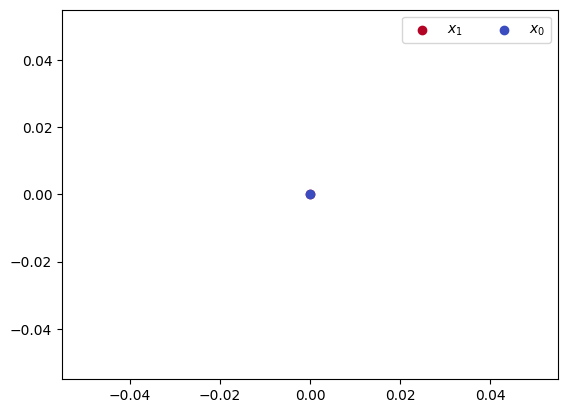

In [14]:
fig, ax = plt.subplots(1, 1)
blue = cm.get_cmap('coolwarm', 2)(0)
red = cm.get_cmap('coolwarm', 2)(1)

ax.scatter([0,], [0], color=red, label='$x_1$')
ax.scatter([0,], [0], color=blue, label='$x_0$')
ax.legend(ncols=2)
fig.savefig('legend.png', dpi=300)